__Revised Profit Strategy__


__New Revised Strategy__

Predicting: Whether a long or short residual-based trade will produce a profitable return over the next N days.

Simpler Terms: If i enter a trade today based on the residual, will i make money within N days?

How the strategy will work:

Looks at the residual today.

    -if its positive -> short WTI, long Brent

    -if its negative -> long WTI, short Brent

Looks at N days ahead and checks:

    -Did the spread between WTI and Brent move in my favor?
    
    -Did it move enough (e.g. atleast $0.50) to be a good trade?

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df_clean = pd.read_csv("../data/processed/df_clean.csv")
df_clean.head(4)


,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10,Residual_Z,Residual_Magnitude,Signal_Strength,Trade_Direction,Price_Ratio
0,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,-4.302400,0.623152,0,0,0,0,1.252050,3.522183,5.652208,1,1.001896
1,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,-4.329001,0.657949,0,1,0,0,-1.593936,5.377729,8.173478,1,0.972901
2,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,-4.389011,0.674523,1,0,1,0,-1.104343,5.133915,7.611179,1,0.980156
3,2005-08-22,65.87,65.46,0.41,-0.7450,0.762810,69.289597,-3.419597,-4.367534,0.699011,0,0,0,0,1.356112,3.419597,4.892052,1,1.006263


In [2]:
# Holding periods
N_values = [3,5,10]
# Minimum profit in spread movement for it to be profitable
profitable_threshold = 0.5

def generate_profit_labels(df_clean, N, threshold):

    """
    Create binary profit labels based on residual-driven trades over N-day horizons.

    Parameters:
    - df: your DataFrame with Residual and Spread
    - N: number of days to simulate holding the trade
    - threshold: profit threshold in spread movement (e.g. 0.50)

    Returns:
    - A binary Series: 1 if trade would have been profitable, else 0
    """
    # determine trade direction: +1 for long (residual < 0), -1 for short (residual) > 0
    
    direction = np.where(df_clean['Residual'] < 0, 1, -1) # 1 -> Long, -1, -> Short
    # Calculate sperad over n days in profitable direction
    spread_move = (df_clean['Spread'].shift(-N)- df_clean['Spread']) * direction

    #Label as 1 if the spread moved enough in profitable direction
    return (spread_move >= threshold).astype(int)

for N in N_values:
    #Create a new column like Profit_Signal_3, etc
    df_clean[f"Profit_Signal_{N}"] = generate_profit_labels(df_clean, N, profitable_threshold)

df_clean.head(300) 


,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10,Residual_Z,Residual_Magnitude,Signal_Strength,Trade_Direction,Price_Ratio
0,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,-4.302400,0.623152,0,0,0,0,1.252050,3.522183,5.652208,1,1.001896
1,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,-4.329001,0.657949,0,1,0,0,-1.593936,5.377729,8.173478,1,0.972901
2,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,-4.389011,0.674523,1,0,1,0,-1.104343,5.133915,7.611179,1,0.980156
3,2005-08-22,65.87,65.46,0.41,-0.7450,0.762810,69.289597,-3.419597,-4.367534,0.699011,0,0,0,0,1.356112,3.419597,4.892052,1,1.006263
4,2005-08-23,65.16,65.81,-0.65,-0.7540,0.760453,69.669825,-4.509825,-4.405726,0.683969,0,1,0,0,-0.152199,4.509825,6.593609,1,0.990123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2006-10-24,56.56,57.55,-0.99,-1.3165,1.718730,60.696441,-4.136441,-4.617234,1.839813,0,0,0,0,0.261327,4.136441,2.248294,1,0.982798
296,2006-10-25,58.79,59.09,-0.30,-1.0635,1.442400,62.369445,-3.579445,-4.347522,1.538229,0,0,0,0,0.499326,3.579445,2.326991,1,0.994923
297,2006-10-26,58.76,60.27,-1.51,-1.0500,1.436593,63.651357,-4.891357,-4.324565,1.525849,0,0,0,0,-0.371460,4.891357,3.205663,1,0.974946
298,2006-10-27,57.99,60.75,-2.76,-0.9975,1.346801,64.172813,-6.182813,-4.262781,1.414965,1,0,0,1,-1.356947,6.182813,4.369587,1,0.954568


_Train/Test Split_

In [3]:

feature_cols = [
    'Residual', 'Spread', 'Spread_RollingMean', 'Spread_RollingStd',
    'Residual_Mean', 'Residual_Std',
    'Residual_Z', 'Residual_Magnitude', 'Signal_Strength',
    'Trade_Direction', 'Price_Ratio'
]
#Drop any rows with missing values in those columns
df_model = df_clean.dropna(subset = feature_cols +['Profit_Signal_10'])

#Create the feature Matrix
X = df_model[feature_cols]



split_date = '2022-01-01'

#Chronologically split data 
X_train = X[df_clean['Date'] < split_date]
X_test = X[df_clean['Date'] > split_date]

#y_3_train = df_model[df_model['Date'] < split_date]['Profit_Signal_3']
#y_3_test  = df_model[df_model['Date'] >= split_date]['Profit_Signal_3']

#y_5_train = df_model[df_model['Date'] < split_date]['Profit_Signal_5']
#y_5_test  = df_model[df_model['Date'] >= split_date]['Profit_Signal_5']

y_10_train = df_model[df_model['Date'] < split_date]['Profit_Signal_10']
y_10_test  = df_model[df_model['Date'] >= split_date]['Profit_Signal_10']



In [4]:
from xgboost import XGBClassifier

#model_3 = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
#model_3.fit(X_train, y_3_train)

#model_5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#model_5.fit(X_train, y_5_train)

model_10 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_10.fit(X_train, y_10_train)

c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

#y_3_pred = model_3.predict(X_test)
#y_5_pred = model_3.predict(X_test)
y_10_pred = model_10.predict(X_test)

# Print reports
#print("=== N = 3 Days ===")
#print(classification_report(y_3_test, y_3_pred))
#print(confusion_matrix(y_3_test, y_3_pred))

#print("\n=== N = 5 Days ===")
#print(classification_report(y_5_test, y_5_pred))
#print(confusion_matrix(y_5_test, y_5_pred))

print("\n=== N = 10 Days ===")
print(classification_report(y_10_test, y_10_pred))
print(confusion_matrix(y_10_test, y_10_pred))


=== N = 10 Days ===
              precision    recall  f1-score   support

           0       0.51      0.74      0.60       375
           1       0.59      0.34      0.43       411

    accuracy                           0.53       786
   macro avg       0.55      0.54      0.52       786
weighted avg       0.55      0.53      0.51       786

[[276  99]
 [270 141]]


Hyperparameter Tuning (GridSearch)

In [6]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier

#Define model and search space
model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
tscv = TimeSeriesSplit(n_splits=5)

#Class weight to handle imbalance
scale_pos_weight = y_10_train.value_counts()[0] / y_10_train.value_counts()[1]

param_grid = {
    'max_depth' : [3,5,7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'scale_pos_weight': [scale_pos_weight]
}
#Define model
grid = GridSearchCV(model, param_grid, cv = tscv, scoring = 'f1', verbose = 1)
#Run Grid Search
grid.fit(X_train, y_10_train)
#Access best model
best_model = grid.best_estimator_



Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:20] WARNING: C:\actio

In [7]:
from sklearn.metrics import classification_report
probs = best_model.predict_proba(X_test)[:,1]

threshold = 0.7
high_conf_indices = probs > threshold

thresholds = [0.5, 0.6, 0.7, 0.8]


for thresh in thresholds:
    selected = probs > threshold
    if selected.sum() == 0:
        print(f"\nThreshold: {thresh} — No trades selected.")
        continue
        
    y_10_pred = best_model.predict(X_test[selected])
    y_true = y_10_test[selected]
    
    print(f"\nThreshold: {thresh}")
    print("Number of Trades:", )
    print(classification_report(y_true, y_10_pred))


Threshold: 0.5
Number of Trades:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.62      1.00      0.77        56

    accuracy                           0.62        90
   macro avg       0.31      0.50      0.38        90
weighted avg       0.39      0.62      0.48        90


Threshold: 0.6
Number of Trades:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.62      1.00      0.77        56

    accuracy                           0.62        90
   macro avg       0.31      0.50      0.38        90
weighted avg       0.39      0.62      0.48        90


Threshold: 0.7
Number of Trades:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.62      1.00      0.77        56

    accuracy                           0.62        90
   macro avg       0.31   

c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [8]:
# print class balance in your n = 10 target label
print(y_10_train.value_counts(normalize=True))

Profit_Signal_10
0    0.546696
1    0.453304
Name: proportion, dtype: float64


In [9]:
def run_backtest(df_model, X_test, probs, threshold=0.7, hold_days=10, profit_target=0.5):
  

    # Align df_test with X_test indices and attach probabilities
    df_test = df_model.iloc[X_test.index].copy()
    df_test = df_test.reset_index(drop=True)
    df_test['Prob'] = probs

    # Filter for high-confidence predictions
    signal_rows = df_test[df_test['Prob'] > threshold].copy()
    signal_rows = signal_rows.reset_index(drop=True)

    trade_logs = []

    for row_idx, row in signal_rows.iterrows():
        exit_idx = row_idx + hold_days
        if exit_idx >= len(df_test):
            continue

        entry_date = row['Date']
        entry_spread = row['Spread']
        residual = row['Residual']
        direction = 1 if residual < 0 else -1

        exit_spread = df_test.iloc[exit_idx]['Spread']
        exit_date = df_test.iloc[exit_idx]['Date']

        pnl = (exit_spread - entry_spread) * direction
        win = 1 if pnl >= profit_target else 0

        trade_logs.append({
            'Date': entry_date,
            'Exit_Date': exit_date,
            'Entry_Spread': entry_spread,
            'Exit_Spread': exit_spread,
            'Residual': residual,
            'PnL': pnl,
            'Win': win,
            'Direction': 'Long' if direction == 1 else 'Short',
            'Prob': row['Prob']
        })

    if not trade_logs:
        print(f"No trades found for threshold = {threshold}")
        return pd.DataFrame()

    trades_df = pd.DataFrame(trade_logs)
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

    return trades_df


trades_df = run_backtest(df_model, X_test, probs, threshold=0.7)
trades_df.head(4)


,Date,Exit_Date,Entry_Spread,Exit_Spread,Residual,PnL,Win,Direction,Prob,Cumulative_PnL
0,2022-01-03,2022-01-18,2.26,3.41,-2.479032,1.15,1,Long,0.859004,1.15
1,2022-02-28,2022-01-19,6.95,2.80,0.471554,4.15,1,Short,0.831566,5.30
2,2022-03-01,2022-01-20,7.27,3.46,0.141217,3.81,1,Short,0.706466,9.11
3,2022-03-02,2022-01-21,8.20,4.59,0.459745,3.61,1,Short,0.811085,12.72


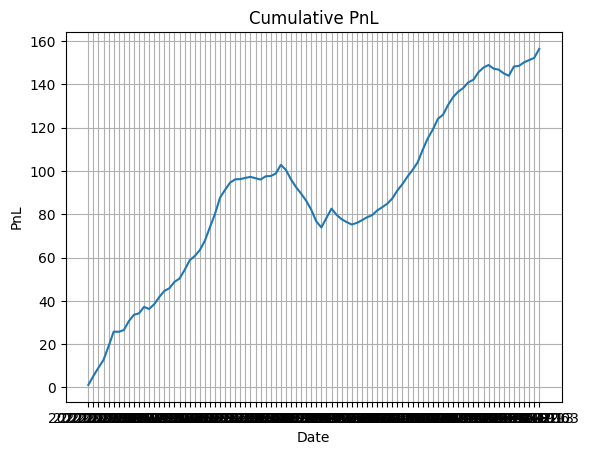

Win Rate: 0.7333333333333333
Total PnL$: 156.34
Sharpe Ratio: 0.65
Total Trades:  4887
Total Profit:  199.80000000000007
Total loss:  -43.460000000000036


In [10]:
trades = run_backtest(df_model, X_test, probs, threshold=0.7)

if not trades.empty:
    

    
    plt.plot(trades['Date'], trades['Cumulative_PnL'])
    plt.title("Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.show()
else:
    print("No trades generated. Try lowering the threshold.")
    # Calculate Sharpe Ratio
if not trades.empty:
    print("Win Rate:", trades['Win'].mean())
    print("Total PnL$:", trades['PnL'].sum())

    # Sharpe Ratio
    mean_pnl = trades['PnL'].mean()
    std_pnl = trades['PnL'].std()
    sharpe = mean_pnl / std_pnl if std_pnl != 0 else 0
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print("Total Trades: " , len(df_model))
    total_profit = trades[trades['PnL'] > 0]['PnL'].sum()
    print("Total Profit: ",total_profit)     
    total_loss = trades[trades['PnL'] < 0]['PnL'].sum()
    print('Total loss: ',total_loss)


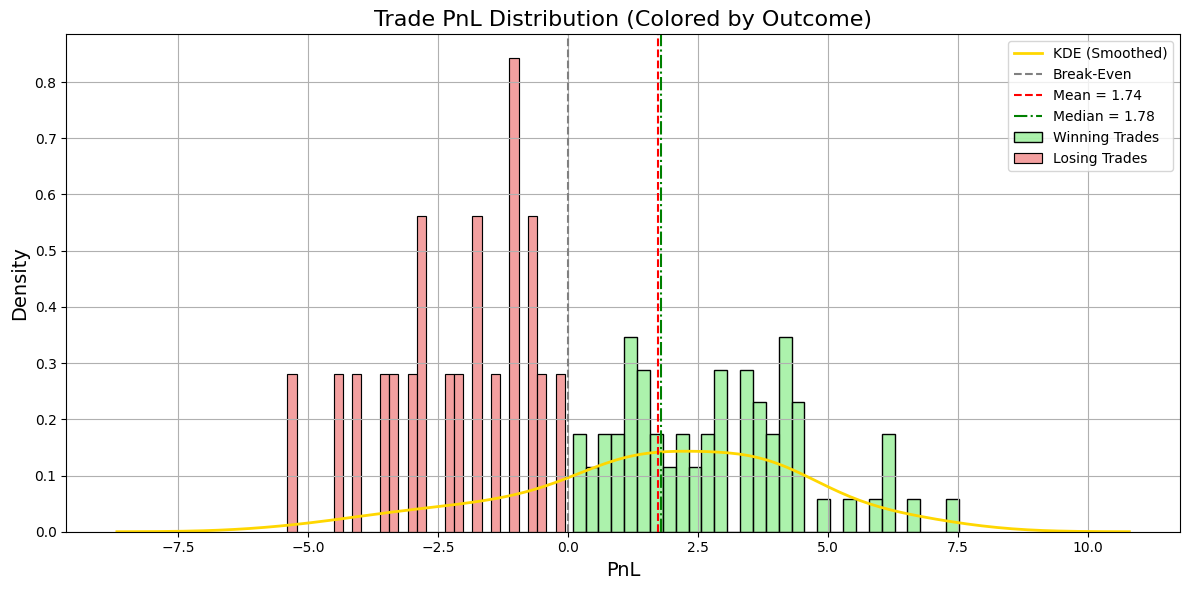

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create masks for positive and negative trades
pnl = trades['PnL']
pnl_pos = pnl[pnl >= 0]
pnl_neg = pnl[pnl < 0]

plt.figure(figsize=(12, 6))

# Plot histogram for positive trades (green)
sns.histplot(
    pnl_pos, 
    bins=30, 
    color='lightgreen', 
    edgecolor='black',
    stat='density',
    label='Winning Trades'
)

# Plot histogram for negative trades (red)
sns.histplot(
    pnl_neg, 
    bins=30, 
    color='lightcoral', 
    edgecolor='black',
    stat='density',
    label='Losing Trades'
)

# KDE for entire distribution (yellow)
sns.kdeplot(
    pnl, 
    color='gold', 
    linewidth=2, 
    label='KDE (Smoothed)'
)

# Add vertical line at break-even
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5, label='Break-Even')

# Add mean and median
mean_pnl = pnl.mean()
median_pnl = pnl.median()
plt.axvline(mean_pnl, color='red', linestyle='--', label=f'Mean = {mean_pnl:.2f}')
plt.axvline(median_pnl, color='green', linestyle='-.', label=f'Median = {median_pnl:.2f}')

# Labels
plt.title("Trade PnL Distribution (Colored by Outcome)", fontsize=16)
plt.xlabel("PnL", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


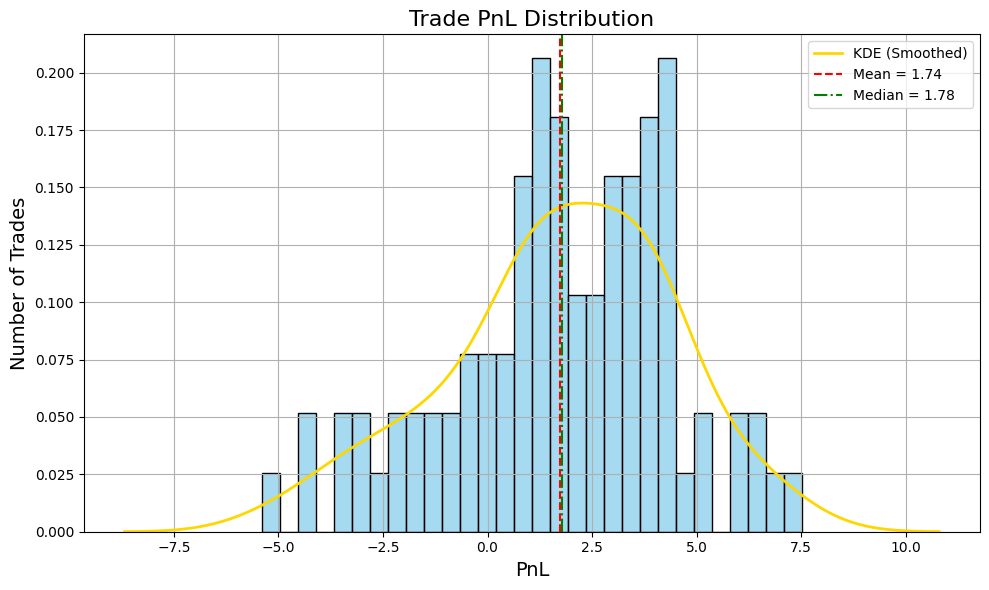

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot histogram only
sns.histplot(
    trades['PnL'],
    bins=30,
    stat = 'density',
    color='skyblue',
    edgecolor='black',
    kde=False  # don't include KDE here
)

# Plot KDE separately
sns.kdeplot(
    trades['PnL'],
    color='gold',
    linewidth=2,
    label='KDE (Smoothed)'
)

# Add mean and median lines
mean_pnl = trades['PnL'].mean()
median_pnl = trades['PnL'].median()
plt.axvline(mean_pnl, color='red', linestyle='--', label=f'Mean = {mean_pnl:.2f}')
plt.axvline(median_pnl, color='green', linestyle='-.', label=f'Median = {median_pnl:.2f}')

# Labels & Title
plt.title("Trade PnL Distribution", fontsize=16)
plt.xlabel("PnL", fontsize=14)
plt.ylabel("Number of Trades", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



_Metrics_

Core Metrics

Drawdown and Risk Metrics

Trade Quality Metrics

Time based Metrics



In [13]:
df_model.head()  # Shows actual trade logs
trades[['Date', 'PnL', 'Direction', 'Prob']].tail(100)
 



,Date,PnL,Direction,Prob
0,2022-01-03,1.15,Long,0.859004
1,2022-02-28,4.15,Short,0.831566
2,2022-03-01,3.81,Short,0.706466
3,2022-03-02,3.61,Short,0.811085
4,2022-03-08,6.28,Short,0.839299
...,...,...,...,...
85,2024-08-22,0.27,Short,0.710659
86,2024-10-01,1.67,Short,0.733758
87,2024-11-06,1.01,Short,0.797326
88,2024-12-03,1.03,Short,0.706802


In [14]:


def get_strategy_metrics(trades_df, name="Strategy"):


    if trades_df.empty:
        print(f"No trades found for {name}")
        return None

    trades_df['Date'] = pd.to_datetime(trades_df['Date'])

    total_trades = len(trades_df)
    num_wins = (trades_df['PnL'] > 0).sum()
    success_rate = num_wins / total_trades if total_trades > 0 else 0
    cumulative_return = trades_df['PnL'].sum()

    days = (trades_df['Date'].max() - trades_df['Date'].min()).days
    trades_per_year = total_trades / (days / 365) if days > 0 else 0

    mean_return = trades_df['PnL'].mean()
    std_dev = trades_df['PnL'].std()

    annualized_return = mean_return * trades_per_year if trades_per_year > 0 else 0
    annualized_volatility = std_dev * np.sqrt(trades_per_year) if trades_per_year > 0 else 0
    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility > 0 else 0

    cum_pnl = trades_df['PnL'].cumsum()
    roll_max = cum_pnl.cummax()
    drawdown = cum_pnl - roll_max
    max_drawdown = drawdown.min()
    max_drawdown_pct = abs(max_drawdown) / roll_max.max() if roll_max.max() > 0 else 0

    return {
        "Strategy": name,
        "Number of Trades": total_trades,
        "Profitable Trades": num_wins,
        "Success Rate (%)": round(success_rate * 100, 2),
        "Cumulative Return ($)": round(cumulative_return, 2),
        "Annualized Return (%)": round(annualized_return * 100, 2),
        "Annualized Volatility (%)": round(annualized_volatility * 100, 2),
        "Sharpe Ratio": round(sharpe_ratio, 2),
        "Max Drawdown (%)": round(max_drawdown_pct * 100, 2)
    }






In [15]:
summary = get_strategy_metrics(trades_df, name="Threshold = 0.7")
summary_df = pd.DataFrame([summary])  # Wrap in list to make a DataFrame

summary_df




,Strategy,Number of Trades,Profitable Trades,Success Rate (%),Cumulative Return ($),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%)
0,Threshold = 0.7,90,70,77.78,156.34,5206.58,1471.51,3.54,18.5


In [16]:
import joblib

joblib.dump(best_model, 'xgboost_model_v2.joblib')  # You can name this anything

df_model.to_csv('df_model.csv', index=False)  # Save the DataFrame to CSV

import json
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)


